# Dataset Setup

In [1]:
from google.colab import files
files.upload()
print("file uploaded successfully")

Saving data.zip to data.zip
file uploaded successfully


In [2]:
!unzip ./data.zip
!mkdir models

Archive:  ./data.zip
  inflating: data/AAPL.csv           
  inflating: data/GOOG.csv           
  inflating: data/taxi.csv           


# Lib Import

In [3]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.6 MB/s eta 0:00:00


In [4]:
import math
from datetime import datetime
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pickle
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, RepeatVector, TimeDistributed
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization

<ipython-input-4-f642e67fce24>:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


# Load Dataset

In [5]:
# loading the dataset
dataset_files = ("./data/AAPL.csv", "./data/GOOG.csv", "./data/taxi.csv")
datasets = [pd.read_csv(dataset_file, index_col=0) for dataset_file in dataset_files]
df_apple, df_google, df_taxi = datasets

# Preprocessing

In [6]:
# checking for null values in the datasets
(
    df_apple.sum().isnull().value,
    df_google.sum().isnull().value,
    df_taxi.sum().isnull().value,
)

(False, False, False)

In [7]:
# normalizing the datasets
std_scalers = (StandardScaler() for i in range(3))
for dataset, scaler in zip(datasets, std_scalers):
  dataset["value"] = scaler.fit_transform(np.array(dataset["value"].values).reshape(-1, 1))

In [8]:
def create_datasets(datasets):
  train = []
  validation = []
  test = []
  
  for dataset in datasets:
    X_train, X_test, y_train, y_test = train_test_split(dataset, np.array(dataset['value']), test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    train.append((X_train, y_train))
    validation.append((X_val, y_val))
    test.append((X_test, y_test))

  return train, validation, test

def create_dataset_with_time_steps(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

def create_datasets_for_nn(train, validation, test, time_steps=1):
  train_nn = []
  validation_nn = []
  test_nn = []
  
  for i, (t, v, te) in enumerate(zip(train, validation, test)):
    train_nn.append(create_dataset_with_time_steps(t[0], t[1], time_steps))
    validation_nn.append(create_dataset_with_time_steps(v[0], v[1], time_steps))
    test_nn.append(create_dataset_with_time_steps(te[0], te[1], time_steps))

  return train_nn, validation_nn, test_nn

In [9]:
train, validation, test = create_datasets(datasets)

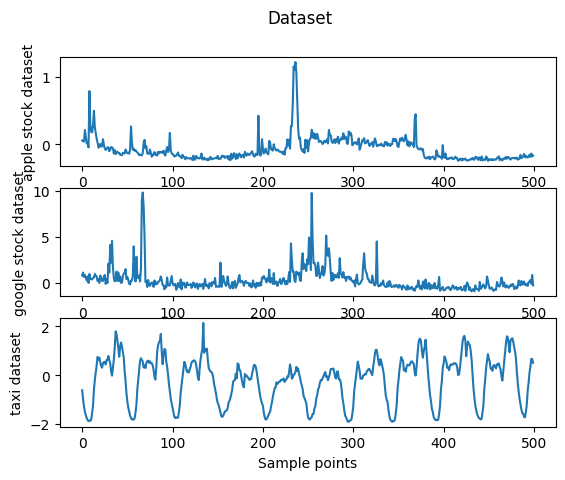

In [10]:
# render datasets
fig, axs = plt.subplots(3, 1)
# to plot first N points
N = 500
x_axis = [i for i in range(N)]

for i, dataset in enumerate(datasets):
  axs[i].plot(x_axis, dataset["value"][:N])

fig.suptitle('Dataset')
axs[0].set_ylabel('apple stock dataset')
axs[1].set_ylabel('google stock dataset')
axs[2].set_ylabel('taxi dataset')
axs[2].set_xlabel('Sample points')

plt.show()

In [11]:
predictions = {
    "SVR": [],
    "NN": [],
    "LSTM": [],
}

# SVR

In [12]:
svrs = [SVR(C=1.0, epsilon=0.2) for i in range(3)]
for dataset, svr, t, v, te in zip(datasets, svrs, train, validation, test):
  svr.fit(np.array(t[0]), np.array(t[1]))
  predictions["SVR"].append(svr.predict(np.array(te[0])))


### In the graph below, the significant distance between the actual value and predictions can be concluded to be an anomaly.

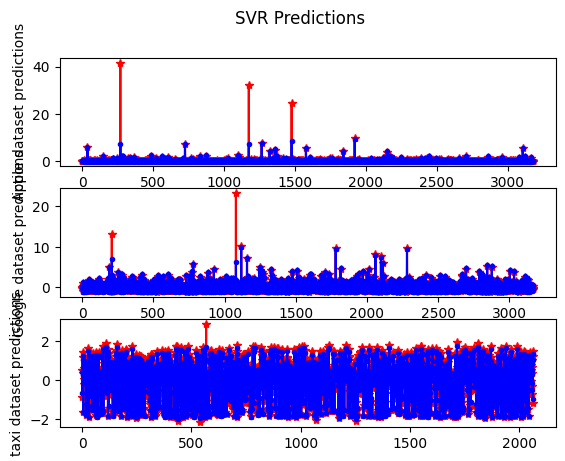

In [13]:
# render predictions
fig, axs = plt.subplots(3, 1)

for i, (te, pred) in enumerate(zip(test, predictions["SVR"])):
  axs[i].plot(te[1], marker="*" ,label='Actual', color='red')
  axs[i].plot(pred, marker=".", label='Prediction', color= 'blue')

fig.suptitle('SVR Predictions')
axs[0].set_ylabel('Apple dataset predictions')
axs[1].set_ylabel('Google dataset predictions')
axs[2].set_ylabel('taxi dataset predictions')

plt.show()


# Neural Networks

In [14]:
train_nn, validation_nn, test_nn = create_datasets_for_nn(train, validation, test)

In [15]:
def build_nn(hp):
  model = keras.Sequential()

  model.add(keras.layers.Dense(
      hp.Int('intial_units', min_value=16, max_value=128, step=16),
      input_shape=(1, 1)
  ))

  for i in range(hp.Int('num_layers', 1, 3)):
    model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=128, step=16), activation='relu'))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_' + str(i), 0, 0.5, 0.1)))
    
  model.add(keras.layers.Dense(1))
  
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mae')


  return model


In [16]:
models_nn = []

map_int_to_dataset = {
    0: 'apple',
    1: 'google',
    2: 'taxi'
}

for i, (t, v) in enumerate(zip(train_nn, validation_nn)):
  tuner = BayesianOptimization(
      build_nn,
      objective='val_loss',
      max_trials=10,
      num_initial_points=2,
      directory='./models/nn',
      project_name=map_int_to_dataset[i]
  )

  # Search for the optimal hyperparameters
  tuner.search(t[0], t[1], epochs=10, validation_data=(v[0], v[1]))

  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  # Build the model with the optimal hyperparameters
  model = tuner.hypermodel.build(best_hps)

  models_nn.append(model)


Trial 10 Complete [00h 00m 12s]
val_loss: 0.8042158484458923

Best val_loss So Far: 0.8037995100021362
Total elapsed time: 00h 01m 47s


In [17]:
# train
for i, (m, t, v, te) in enumerate(zip(models_nn, train_nn, validation_nn, test_nn)):
  m.fit(
      t[0], t[1],
      epochs=10,
      batch_size=32,
      validation_data=(v[0], v[1]),
      shuffle=False
  )

  predictions["NN"].append(m.predict(np.array(te[0])))


Epoch 1/10
318/318 [==============================] - 2s 3ms/step - loss: 0.1831 - val_loss: 0.1791
Epoch 2/10
318/318 [==============================] - 1s 3ms/step - loss: 0.1805 - val_loss: 0.1791
Epoch 3/10
318/318 [==============================] - 1s 3ms/step - loss: 0.1805 - val_loss: 0.1790
Epoch 4/10
318/318 [==============================] - 1s 3ms/step - loss: 0.1805 - val_loss: 0.1790
Epoch 5/10
318/318 [==============================] - 1s 2ms/step - loss: 0.1805 - val_loss: 0.1791
Epoch 6/10
318/318 [==============================] - 1s 2ms/step - loss: 0.1805 - val_loss: 0.1790
Epoch 7/10
318/318 [==============================] - 1s 3ms/step - loss: 0.1805 - val_loss: 0.1790
Epoch 8/10
318/318 [==============================] - 1s 3ms/step - loss: 0.1805 - val_loss: 0.1791
Epoch 9/10
318/318 [==============================] - 1s 3ms/step - loss: 0.1805 - val_loss: 0.1790
Epoch 10/10
100/100 [==============================] - 0s 1ms/step
Epoch 1/10
317/317 [=============

In [18]:
for i, model in enumerate(models_nn):
  pickle.dump(model, open(f"./models/{map_int_to_dataset[i]}_nn.pkl", 'wb'))

print("models saved successfully!")

models saved successfully!


# LSTM

In [19]:
def build_lstm(hp):
  model = keras.Sequential()

  model.add(keras.layers.LSTM(
      units=hp.Int('units_1', min_value=16, max_value=80, step=16),
      input_shape=(1, 1)
  ))
  model.add(keras.layers.Dropout(rate=hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1)))
  model.add(keras.layers.RepeatVector(n=1))
  model.add(keras.layers.LSTM(units=hp.Int('units_2', min_value=16, max_value=80, step=16), return_sequences=True))
  model.add(keras.layers.Dropout(rate=hp.Float('dropout_2', min_value=0, max_value=0.5, step=0.1)))
  model.add(
    keras.layers.TimeDistributed(
      keras.layers.Dense(units=1)
    )
  )

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mae')

  return model

In [20]:
models_lstm = []

for i, (t, v) in enumerate(zip(train_nn, validation_nn)):
  tuner = BayesianOptimization(
      build_lstm,
      objective='val_loss',
      max_trials=10,
      num_initial_points=2,
      directory='./models/lstm',
      project_name=map_int_to_dataset[i]
  )

  # Search for the optimal hyperparameters
  tuner.search(t[0], t[1], epochs=10, validation_data=(v[0], v[1]))

  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  # Build the model with the optimal hyperparameters
  model = tuner.hypermodel.build(best_hps)

  models_lstm.append(model)


Trial 10 Complete [00h 00m 19s]
val_loss: 0.8042409420013428

Best val_loss So Far: 0.804082453250885
Total elapsed time: 00h 03m 58s


In [21]:
# train
for i, (m, t, v, te) in enumerate(zip(models_lstm, train_nn, validation_nn, test_nn)):
  m.fit(
      t[0], t[1],
      epochs=10,
      batch_size=32,
      validation_data=(v[0], v[1]),
      shuffle=False
  )

  predictions["LSTM"].append(m.predict(np.array(te[0])))


Epoch 1/10
318/318 [==============================] - 7s 8ms/step - loss: 0.1810 - val_loss: 0.1791
Epoch 2/10
318/318 [==============================] - 2s 5ms/step - loss: 0.1805 - val_loss: 0.1791
Epoch 3/10
318/318 [==============================] - 2s 5ms/step - loss: 0.1805 - val_loss: 0.1791
Epoch 4/10
318/318 [==============================] - 2s 6ms/step - loss: 0.1805 - val_loss: 0.1791
Epoch 5/10
318/318 [==============================] - 2s 6ms/step - loss: 0.1805 - val_loss: 0.1791
Epoch 6/10
318/318 [==============================] - 2s 5ms/step - loss: 0.1805 - val_loss: 0.1791
Epoch 7/10
318/318 [==============================] - 2s 5ms/step - loss: 0.1805 - val_loss: 0.1791
Epoch 8/10
318/318 [==============================] - 2s 5ms/step - loss: 0.1805 - val_loss: 0.1791
Epoch 9/10
318/318 [==============================] - 1s 5ms/step - loss: 0.1805 - val_loss: 0.1790
Epoch 10/10
100/100 [==============================] - 1s 2ms/step
Epoch 1/10
317/317 [=============

In [22]:
for i, model in enumerate(models_lstm):
  pickle.dump(model, open(f"./models/{map_int_to_dataset[i]}_lstm.pkl", 'wb'))

print("LSTM Models saved successfully!")

LSTM Models saved successfully!
